In [122]:
# Import Libraries

## for data
from sklearn import metrics, manifold
import numpy as np
import pandas as pd
import json

## for processing
from gensim.models import Word2Vec
import gensim.downloader as gensim_api
import gensim, nltk, re

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
#Create a data frame to store bond data
bond_data_frame = pd.read_csv("ballottext_bonds_CA.csv") 
bond_data_frame = bond_data_frame.rename(columns={"ballottext":"original_text"})

In [124]:
#Clean the text data 

# create a set for O(1) of stop words to filter
stopwords = set(nltk.corpus.stopwords.words("english"))

# initalize a object to get root words
lem = nltk.stem.wordnet.WordNetLemmatizer()

def clean_text(text):
    #removes punctuation within a word and makes everything lower case
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    #split sentence into list
    sentence_list = text.split()    
    
    #removes stop words
    sentence_list = [x for x in sentence_list if x not in stopwords]        
    for i, word in enumerate(sentence_list):
        sentence_list[i] = lem.lemmatize(word)
                
    ## back to string from list
    text = " ".join(sentence_list)
    
    return text

In [125]:
#Add column to dataframe with cleaned text
bond_data_frame["clean_text"] = bond_data_frame["original_text"].apply(lambda x: clean_text(x))
bond_data_frame.head()

,original_text,clean_text
0,To renovate and equip classrooms and school fa...,renovate equip classroom school facility distr...
1,"To improve safety, energy efficiency, lower ma...",improve safety energy efficiency lower mainten...
2,Shall the Acalanes Union High School District ...,shall acalanes union high school district auth...
3,"To establish a ten-year technology fund, upgra...",establish tenyear technology fund upgrade inst...
4,"To design and construct permanent classrooms, ...",design construct permanent classroom science l...


In [126]:
#frequency analysis to determine classes 
from collections import defaultdict
word_freq = defaultdict(int)

for line in bond_data_frame["clean_text"]:
    for word in line.split():
        word_freq[word] += 1

potential_label_lst = []

lower_bound = sorted(word_freq.values(), reverse=True)[50]

for potential_label in word_freq:
    if word_freq[potential_label] > lower_bound:
        potential_label_lst.append(potential_label)

print(potential_label_lst)

['renovate', 'classroom', 'school', 'facility', 'student', 'access', 'technology', 'education', 'including', 'science', 'replace', 'roof', 'system', 'shall', 'unified', 'district', 'issue', 'bond', 'interest', 'rate', 'legal', 'limit', 'independent', 'citizen', 'oversight', 'money', 'administrator', 'salary', 'fund', 'improve', 'safety', 'high', 'union', 'million', 'committee', 'audit', 'improvement', 'new', 'upgrade', 'electrical', 'repair', 'construct', 'provide', 'state', 'acquire', 'annual', 'computer', 'plumbing', 'elementary', 'local']


In [127]:
#After doing frequency analysis of what the most common words are

# The five classes that I have come up with are 

#renovation, salary, technology, construction, classroom
categories = ["renovation", "salary", "technology", "construction", "classroom"]

In [50]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [141]:
#Form cluster dictionaries 
def get_similar_words(lst_words):
    lst_out = lst_words
    for tupla in nlp.most_similar(lst_words, topn=10):
        lst_out.append(tupla[0])
    return list(set(lst_out))

dic_clusters = {}

dic_clusters["renovation"] = get_similar_words(['renovate','improvement','upgrade','repair'])
dic_clusters["salary"] = get_similar_words(['salary','money', 'facility','administrator', "amount"])
dic_clusters["technology"] = get_similar_words(['technology','computer','app'])
dic_clusters["construction"] = get_similar_words(['construction','build','design','new'])
dic_clusters["classroom"] = get_similar_words(['classroom','class', 'books', 'education'])

mapping = {}

for key in dic_clusters.keys():
    for elm in dic_clusters[key]:
        mapping[clean_text(elm)] = key 

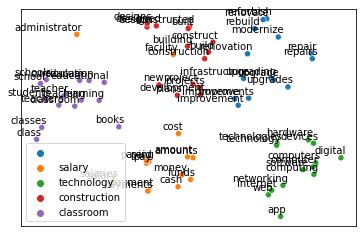

In [142]:
#Visualize 

## word embedding
tot_words = [word for v in dic_clusters.values() for word in v]
X = nlp[tot_words]

## pca
pca = manifold.TSNE(perplexity=40, n_components=2, init='pca')
X = pca.fit_transform(X)

## create dtf
dtf = pd.DataFrame()
for k,v in dic_clusters.items():
    size = len(dtf) + len(v)
    dtf_group = pd.DataFrame(X[len(dtf):size], columns=["x","y"], 
                             index=v)
    dtf_group["cluster"] = k
    dtf = dtf.append(dtf_group)

#Visualize clusters 
fig, ax = plt.subplots()
sns.scatterplot(data=dtf, x="x", y="y", hue="cluster", ax=ax)
ax.legend().texts[0].set_text(None)
ax.set(xlabel=None, ylabel=None, xticks=[], xticklabels=[], 
       yticks=[], yticklabels=[])
for i in range(len(dtf)):
    ax.annotate(dtf.index[i], 
               xy=(dtf["x"].iloc[i],dtf["y"].iloc[i]), 
               xytext=(5,2), textcoords='offset points', 
               ha='right', va='bottom')

In [143]:
# Iterate through the bonds and look for overlapping words with class and similar words of classes
classifications = []
for line in bond_data_frame["clean_text"]:
    q = line.split(" ")
    for i, word in enumerate(q):
        if word in mapping:
            classifications.append(mapping[word])
            break
 
bond_data_frame["classifications"] = classifications

In [144]:
#Print the first few classifications from the dataframe
bond_data_frame.head()

,original_text,clean_text,classifications
0,To renovate and equip classrooms and school fa...,renovate equip classroom school facility distr...,renovation
1,"To improve safety, energy efficiency, lower ma...",improve safety energy efficiency lower mainten...,renovation
2,Shall the Acalanes Union High School District ...,shall acalanes union high school district auth...,classroom
3,"To establish a ten-year technology fund, upgra...",establish tenyear technology fund upgrade inst...,technology
4,"To design and construct permanent classrooms, ...",design construct permanent classroom science l...,construction


In [145]:
#Print the last few classifications from the dataframe

bond_data_frame.tail()

,original_text,clean_text,classifications
1910,To avoid further overcrowding by building one ...,avoid overcrowding building one new elementary...,construction
1911,To fund school facilities for students in the ...,fund school facility student yuba city unified...,salary
1912,Shall the Yuba City Unified School District is...,shall yuba city unified school district issue ...,classroom
1913,To repair and upgrade local schools in Yucaipa...,repair upgrade local school yucaipa calimesa p...,renovation
1914,To repair and upgrade local schools in Yucaipa...,repair upgrade local school yucaipa calimesa p...,renovation
